<div align=center>

<font size=5>
    In the Name of God
<font/>
<br/>
<br/>
<font>
    Sharif University of Technology - Departmenet of Electrical Engineering
</font>
<br/>
<font>
    Introducing with Machine Learing - Dr. S. Amini
</font>
<br/>
<br/>
Spring 2023

</div>

<hr/>
<div align=center>
<font size=6>
    Neural Networks Practical Assignment
    
    Question 1
</font>
<br/>		
<font size=4>
<br/>
</div>

# Personal Data

In [1]:
# Set your student number
student_number = 99106255
Name = 'Alireza'
Last_Name = 'Shokrani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [2]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

You should consider upgrading via the 'C:\Users\Alireza\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Alireza\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Alireza\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Alireza\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Importing Libraries

In [3]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [4]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [5]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [6]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class

- **Hint**:  You can use `plt.subplots` for visualization

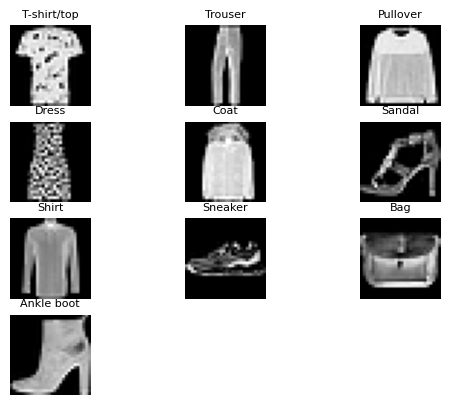

In [7]:
## FILL HERE

seed = np.random.randint(1, len(train_set))
i = 0
while i < num_classes:
    if train_set[seed][1] == i:
        plt.subplot(4, 3, i+1)
        plt.imshow(train_set[seed][0][0,:,:], 'gray')
        plt.axis('off')
        plt.title(FashionMNIST.classes[i], fontsize = 8)
        i += 1
    seed += 1
    if seed >= len(train_set):
        seed = 0

plt.show()


## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [8]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [9]:
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

parameters['w0'].shape


torch.Size([784, 512])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [10]:
def affine_forward(x, w, b):
    ## FILL HERE
    return torch.matmul(x, w) + b.repeat(x.shape[0],1)


def relu(x):
    ## FILL HERE
    return (x > 0) * x

Function `model` returns output of the whole model for the input `x` using the parameters:

In [11]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)

    ## FILL HERE
    for i in range(num_layers - 1):
        x = relu(affine_forward(x, parameters[f'w{i}'], parameters[f'b{i}']))
    x = affine_forward(x, parameters[f'w{num_layers - 1}'], parameters[f'b{num_layers - 1}'])
    return x

Implementing cross entropy loss:

In [13]:
def cross_entropy_loss(scores, y):
    n = len(y)
    ## FILL HERE
    return torch.sum(torch.log(torch.sum(torch.exp(scores), 1)) - scores[range(len(y)),y])



Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [14]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient (parameter.grad). Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    ## FILL HERE
    with torch.no_grad():
        for parameter in parameters.values():
            parameter -= learning_rate * parameter.grad

    for parameter in parameters.values():
        parameter.grad.zero_()


Training functions:

In [15]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    ## FILL HERE
    acc = sum((y_pred == y_true)*1) / len(y_true)
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using loss.backward() method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE
        loss = cross_entropy_loss(p, y)
        loss.backward()
        sgd_optimizer(parameters, learning_rate)
        train_loss += loss

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
        

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    train_loss /= N_train
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE
        loss = cross_entropy_loss(p, y)
        total_loss += loss

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [16]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [17]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        ## FILL HERE
        ## You should calculate the train and test loss and accuracies for each epoch and add them to
        ## the lists `train_losses`, `test_losses`, `train_accuracies` and `test_accuracies`
        train_loss, train_acc = train(train_loader, learning_rate)
        test_loss, test_acc = validate(test_loader, set_name=str(epoch))
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_acc.item())
        test_accuracies.append(test_acc.item())
        print("train loss: " + str(train_loss.item()))
        
    return train_losses, test_losses, train_accuracies, test_accuracies
    ## plot the loss history of training and test sets 
    ## FILL HERE

    ## plot the accuracy history of training and test sets
    ## FILL HERE

In [18]:
# train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

num_epochs=25
learning_rate=0.005
train_losses, test_losses, train_accuracies, test_accuracies = train_model([train_loader, test_loader], num_epochs, learning_rate)


Accuracy of train set: 0.6917
Accuracy of 0 set: 0.8354833333333334
train loss: 0.7926463484764099
Accuracy of train set: 0.8357
Accuracy of 1 set: 0.86445
train loss: 0.44454067945480347
Accuracy of train set: 0.8567166666666667
Accuracy of 2 set: 0.8704166666666666
train loss: 0.3848303258419037
Accuracy of train set: 0.8682833333333333
Accuracy of 3 set: 0.8795666666666667
train loss: 0.3552749454975128
Accuracy of train set: 0.8786166666666667
Accuracy of 4 set: 0.8922166666666667
train loss: 0.32739362120628357
Accuracy of train set: 0.884
Accuracy of 5 set: 0.8937333333333334
train loss: 0.31337225437164307
Accuracy of train set: 0.89045
Accuracy of 6 set: 0.8753833333333333
train loss: 0.2945113480091095
Accuracy of train set: 0.8947
Accuracy of 7 set: 0.8916166666666666
train loss: 0.2838522493839264
Accuracy of train set: 0.8966166666666666
Accuracy of 8 set: 0.9046
train loss: 0.2744142711162567
Accuracy of train set: 0.8997333333333334
Accuracy of 9 set: 0.9063
train loss: 0

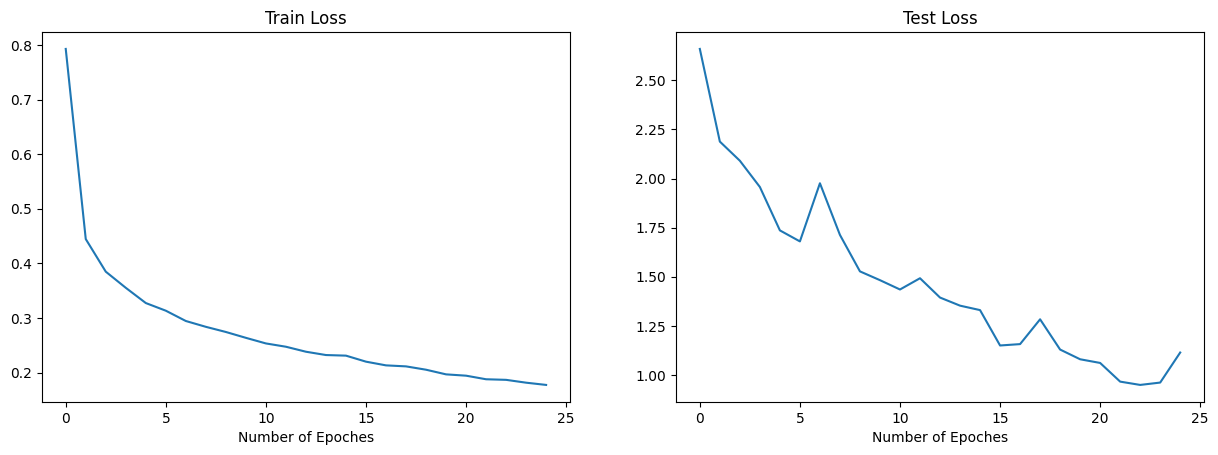

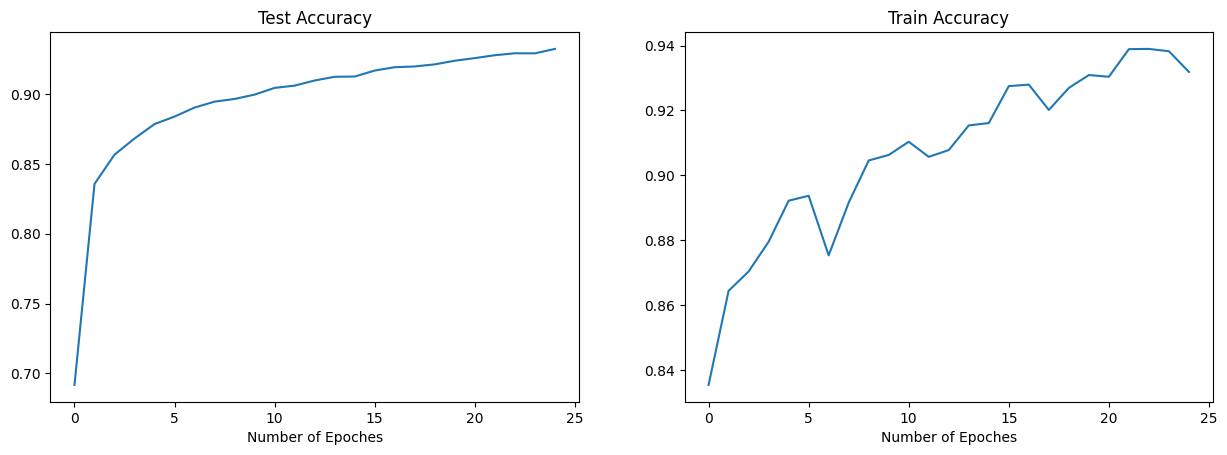

In [41]:
plt.figure().set_figwidth(15)
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Train Loss")
plt.xlabel("Number of Epoches")
plt.subplot(1, 2, 2)
plt.plot(test_losses)
plt.title("Test Loss")
plt.xlabel("Number of Epoches")
plt.show()

plt.figure().set_figwidth(15)
plt.subplot(1, 2, 1)
plt.plot(train_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Number of Epoches")
plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title("Train Accuracy")
plt.xlabel("Number of Epoches")
plt.show()

In [42]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.9318666666666666


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

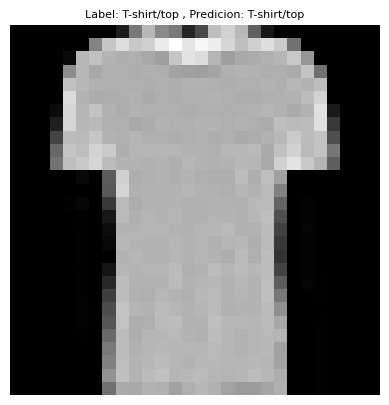

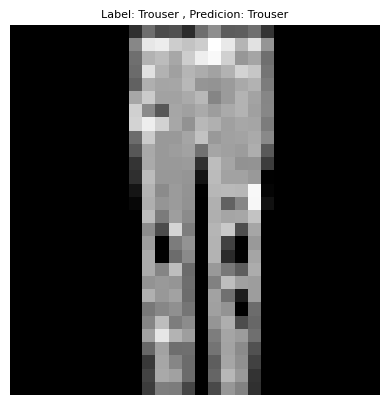

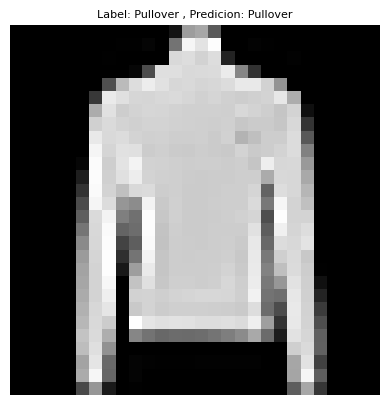

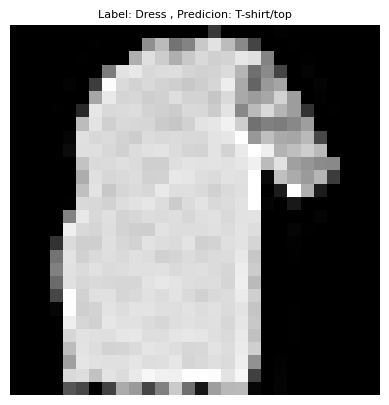

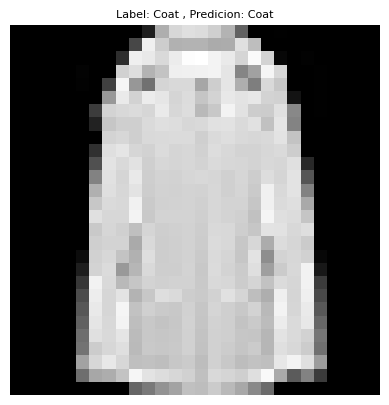

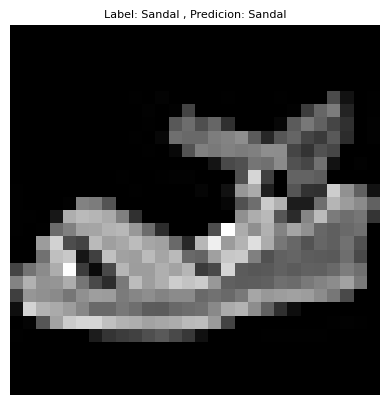

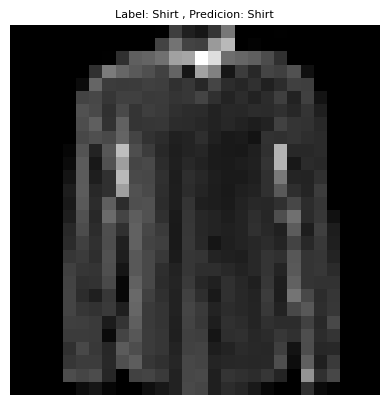

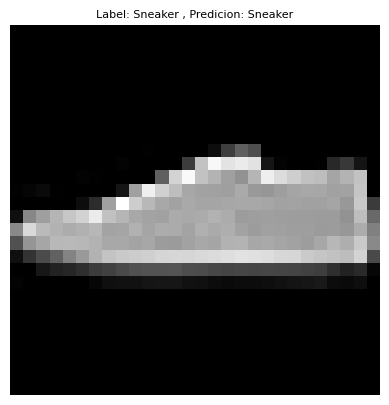

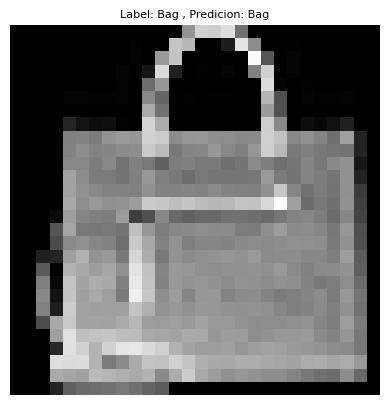

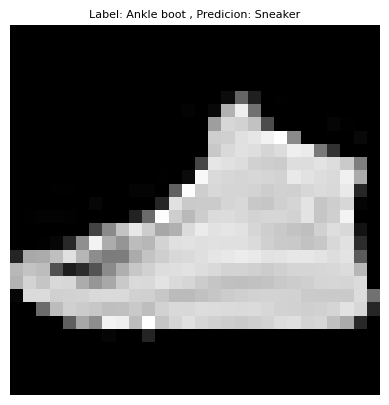

In [108]:
## FILL HERE
batch_num = 20
for i in range(batch_num):
    batch, labels = next(iter(test_loader))

scores = model(batch, parameters, num_layers)
pred = scores.argmax(dim=-1)

i = 0
j = 0
b = np.ones(10)
while b.any():
    # if i >= num_classes:
    #     break
    if j >= 64:
        j = 0
    if labels[j] == i:
        plt.imshow(batch[j][0,:,:], 'gray')
        plt.axis('off')
        plt.title("Label: " + str(FashionMNIST.classes[i]) + " , Predicion: " + str(FashionMNIST.classes[pred[j]]), fontsize = 8)
        plt.show()
        b[i] = 0
        i += 1
    j += 1

